# Load the packages and files

In [1]:
import numpy as np
import sys
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import h5py
from scipy.io import loadmat
import matplotlib as mpl
import time
import gsw
from matplotlib.colors import TwoSlopeNorm

# import existing python files
plt.rcParams['figure.figsize'] = (10,4)

# add rdmds reading functions to path
sys.path.append("/home/mmurakami/MITgcm/MITgcm_c68r/MITgcm-checkpoint68r/utils/python/MITgcmutils/MITgcmutils/") # go to parent dir
from mds import *

# add the other files
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")
from read_binary import *
from calc_UV_conv_1face import calc_UV_conv_1face
from calc_mskmean_T_mod import calc_mskmean_T_mod
from mk3D_mod import mk3D_mod
from aste_helper_funcs import *
from timing_functions import *           # ts2dte, get_fnames, etc.
from binning import *                    # bin_array, create_mesh

# ignore memory warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
sys.path.append("/home/mmurakami/crios_backups/an_helper_functions")

from get_Jterms import *

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)
LwetC2d 146614
LwetC 4833023



In [3]:
%run /home/mmurakami/crios_backups/an_helper_functions/prep_grid.py

(50,) (50, 1350, 270)
hf1 (1350, 270)
(1, 1350, 270)
LwetC2d 146614
LwetC 4833023



# where do we want to save the graphics?

In [4]:
path = "figs/WMT"

# Read the masks for the total Barents Sea

In [6]:
mymsk = np.zeros((ny,nx))
idxs = np.where(mskBasin == 6)

for i,j in zip (idxs[0],idxs[1]):
    mymsk[i,j] = 1

# Get the timesteps

In [7]:
# ocean and ice
AB_gT=0
AB_gS=0

In [51]:
# define the years of this that we want to read from
# create an array of the time steps we want to read
# use ts2dte to get december 2014
# first make an array of filenames
dt_aste = 600
startyr = 2002
endyr = 2019

# all the filenames in the system
fnames = get_fnames(dt_aste,startyr,endyr)

times = {}
# times["2014"] = np.arange(3,5,1)
# print(times)

times["2006"] = np.array([12])
times["2007"] = np.arange(1,4,1)
# times["2013"] = np.array([12])
# times["2014"] = np.arange(1,4,1)



# the filenames we want for 2014
tsstr,datetimes = get_tsteps(times,fnames,dt_aste,startyr,1,1)

t2 = int(tsstr[1])    # this is the averages file that we want to read from when we do budgeting


dt = datetimes[1]-datetimes[0]   # days
dt = dt.total_seconds()
dt

2678400.0

In [52]:
tsteps = len(datetimes)-1
tsteps

3

# Do the salt budget

In [53]:
# set the mask we want to use
mymsk = mymsk
iB = 6 # redundant, but we use for the Barents Sea
titlestr = "Lind "  # for plotting so we know and save correctly

In [54]:
# set a larger array for one year of the terms
nS,nT = 112,112
vol_mesh_all = np.zeros((tsteps,nS,nT))
JtermsT_all = np.zeros((tsteps,5,nS,nT))  # recall this is in the format tend, adv, df, kpp, and surface
JtermsS_all = np.zeros((tsteps,5,nS,nT))
JtermsT_nn_all = np.zeros((tsteps,5,nS,nT))
JtermsS_nn_all = np.zeros((tsteps,5,nS,nT))

In [55]:
# plt.pcolormesh(get_aste_tracer(mymsk,nfx,nfy)[0])
vol = np.tile(mygrid['DXG'][np.newaxis,:,:],(50,1,1)) * np.tile(mygrid['DYG'][np.newaxis,:,:],(50,1,1)) * DRF3d
# vol = np

In [56]:
# np.nansum(vol_mesh)

In [57]:
dterm = 10  # for upper 100 m
for i in range(len(datetimes)-1):
    print(datetimes[i])
    tsstrhere = tsstr[i:i+2]
    datetimeshere = datetimes[i:i+2]
    dt = datetimes[i+1]-datetimes[i]
    dt = dt.total_seconds()
    t2 = int(tsstr[i+1])

    # run the function - check if this works
    vol_mesh,JtermsT,JtermsS,JtermsT_nn,JtermsS_nn = get_Jterms(fnames,tsstrhere,datetimeshere,dt,t2,mymsk,iB,RAC,RAC3,myparms,dterm)

    vol_mesh_all[i] = vol_mesh
    JtermsT_all[i] = JtermsT
    JtermsS_all[i] = JtermsS
    JtermsT_nn_all[i] = JtermsT_nn
    JtermsS_nn_all[i] = JtermsS_nn

2006-12-01 00:00:00
doing salt budget
doing heat budget
2
doing volume
doing TS binning
creating the J terms now
doing JtermsT
total residual -1.2053938207594273e-13 Sv/PSU
doing JtermsS
total residual 1.184375018650219e-13 Sv/degC
doing not normalized J terms
total residual -1.2053938207594273e-13 Sv
total residual 1.184375018650219e-13 Sv
2007-01-01 00:00:00
doing salt budget
doing heat budget
2
doing volume
doing TS binning
creating the J terms now
doing JtermsT
total residual 6.019615758988243e-14 Sv/PSU
doing JtermsS
total residual 1.0264224301521063e-12 Sv/degC
doing not normalized J terms
total residual 6.019615758988243e-14 Sv
total residual 1.0264224301521063e-12 Sv
2007-02-01 00:00:00
doing salt budget
doing heat budget
2
doing volume
doing TS binning
creating the J terms now
doing JtermsT
total residual 4.336500581707454e-13 Sv/PSU
doing JtermsS
total residual 4.367121584789182e-12 Sv/degC
doing not normalized J terms
total residual 4.336500581707454e-13 Sv
total residual 4.

In [58]:
# reset the mean volume based on the terms
JtermsT = np.nanmean(JtermsT_all,axis=0)
JtermsS = np.nanmean(JtermsS_all,axis=0)
vol_mesh = np.nanmean(vol_mesh_all,axis=0)

JtermsS_nn = np.nanmean(JtermsS_nn_all,axis=0)
JtermsT_nn = np.nanmean(JtermsT_nn_all,axis=0)

# set the T-S mesh

In [59]:
cmap = plt.get_cmap('RdBu_r',31).copy()
cmap.set_under(color='white')
cmap2 = plt.get_cmap('viridis',31).copy()
cmap2.set_under(color='white')

In [60]:
copypath = "/scratch/mmurakami/ASTE_270/LAYERS_copies/"
filename = "layers2TH"
boundsT = rdmds(copypath + filename)
binsTH_edges = boundsT.reshape(boundsT.shape[0])
binsTH_centers = (binsTH_edges[:-1] + binsTH_edges[1:])/2
nT = binsTH_edges.shape[0]-1

filename = "layers1SLT"
boundsS = rdmds(copypath + filename)
binsSLT_edges = boundsS.reshape(boundsS.shape[0])
binsSLT_centers = (binsSLT_edges[:-1] + binsSLT_edges[1:])/2
nS = binsSLT_edges.shape[0]-1

binwidthT = binsTH_edges[1:] - binsTH_edges[:-1]
binwidthS = binsSLT_edges[1:] - binsSLT_edges[:-1]
dT,dS = np.meshgrid(binwidthT,binwidthS)
dT = dT.reshape(112,112,1)
dS = dS.reshape(112,112,1)

Tbin,Sbin = np.meshgrid(binsTH_edges,binsSLT_edges)
Tbincent,Sbincent = np.meshgrid(binsTH_centers,binsSLT_centers)

binwidthsS_tile = np.tile(binwidthS, (112, 1)).T
binwidthsT_tile = np.tile(binwidthT, (112, 1))

In [61]:

# add the isopycnals
# add the density contours from gsw
smin = 25.5 - (0.01 * 25.5)    #salt_ctrl_subregR.min - (0.01 * salt_ctrl_subregR.min)
smax = 38 + (0.01 * 38)    #salt_ctrl_subregR.max + (0.01 * salt_ctrl_subregR.max)
tmin = -2 + (0.1 * -2)       #temp_ctrl_subregR.min - (0.1 * temp_ctrl_subregR.max)
tmax = 31 + (0.1 * 31)       #temp_ctrl_subregR.max + (0.1 * temp_ctrl_subregR.max)
print('tmin, tmax, smin, smax sizes=,', tmin, tmax, smin, smax)
# Calculate how many gridcells we need in the x and y dimensions
xdim = 50
ydim = 50
# Create empty grid of zeros
dens = np.zeros((ydim,xdim))
# Create temp and salt vectors of appropiate dimensions
ti = np.linspace(-2,31,ydim)
si = np.linspace(25.5,38,xdim)
Freez_temp = gsw.CT_freezing(si,0,0)

Si, Ti = np.meshgrid(si, ti, sparse=False, indexing='ij')
# Loop to fill in grid with densities
for j in range(0,int(ydim)):
    for i in range(0, int(xdim)):
        #print(si[i],ti[j])
        dens[j,i]=gsw.rho(si[i],ti[j],0)
        # Substract 1000 to convert to sigma-0
dens2 = dens - 1000

tmin, tmax, smin, smax sizes=, -2.2 34.1 25.245 38.38


# do a sample plot of the tendencies

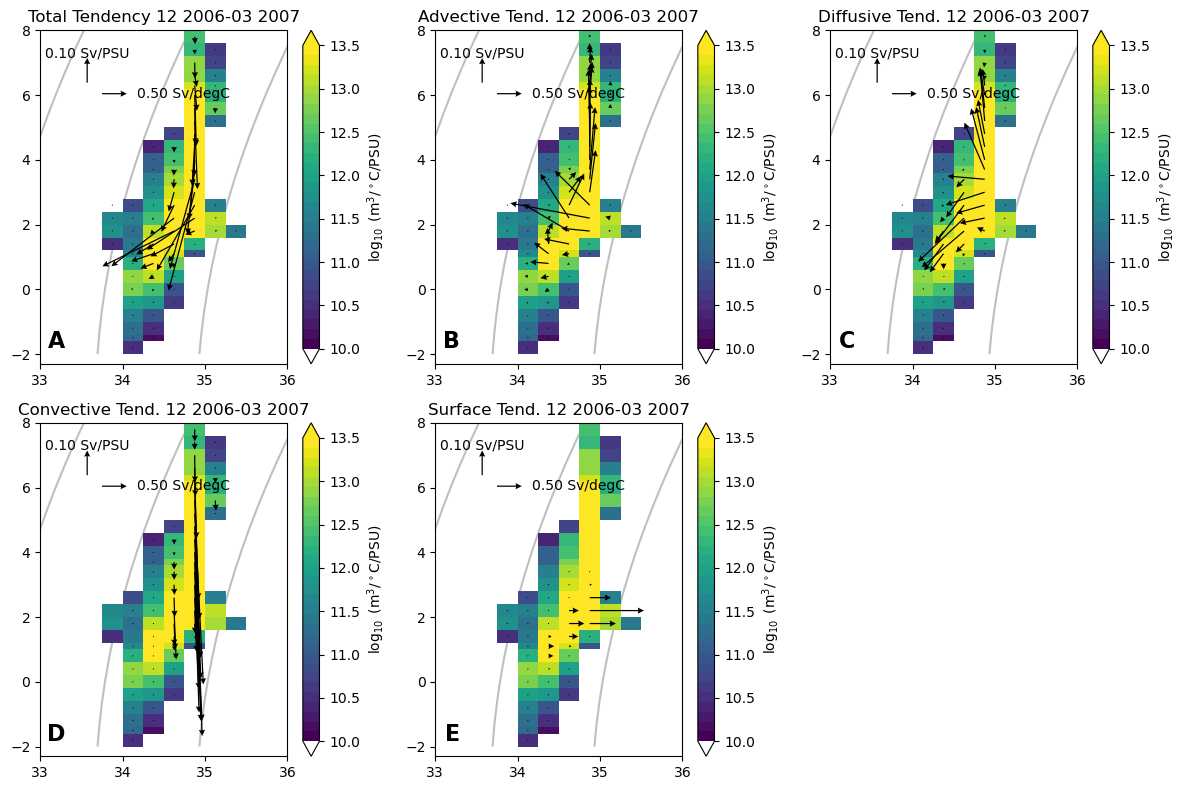

In [62]:
# Define constants
alpha, beta = 1, 0.2
arrow_length, step, t, U, scale = 0.25, 2, 0, .5, 5e0
ypos1, ypos2, xpos1, xpos2 = 0.81, 0.88, 0.35, 0.19

# Time string for labeling
# timestr = datetimes[0].strftime("%Y") + "-" + datetimes[-1].strftime("%Y")
timestr = datetimes[0].strftime("%m %Y") + "-" +datetimes[-1].strftime("%m %Y")
# timestr = "2010"

# Plot limits
xlims, ylims = np.array([33, 36]), np.array([-2.3, 8])

# Titles for each subplot
titles = [
    "Total Tendency", "Advective Tend.", "Diffusive Tend.",
    "Convective Tend.", "Surface Tend.", "Sum of Tendencies"
]

# Figure setup
fig, axes = plt.subplots(2, 3, figsize=(12, 8))  # 2x3 subplot layout
axes = axes.flatten()  # Flatten to iterate easily

for i, ax in enumerate(axes[:-1]):
    if i < 5:
        U1, V1 = JtermsS[i], JtermsT[i]  # Select tendency terms
    else:
        # Sum up all terms for the last plot
        U1, V1 = sum(JtermsS[1:5]), sum(JtermsT[1:5])

    # Apply scaling and set zero values to NaN
    U1, V1 = U1 * alpha, V1 * beta
    U1[U1 == 0], V1[V1 == 0] = np.nan, np.nan

    # Background colormap
    cb = ax.pcolormesh(Sbin, Tbin, np.log10(vol_mesh), cmap=cmap2, vmin=10, vmax = 13.5,zorder=2)

    # Quiver plot
    # q = ax.quiver(Sbincent[::step, ::step], Tbincent[::step, ::step], 
                  # U1[::step, ::step], V1[::step, ::step], 
                  # width=0.005, scale=scale, zorder=3, headwidth=5)
    q = ax.quiver(Sbincent, Tbincent, 
                  U1, V1, 
                  width=0.005, scale=scale, zorder=3, headwidth=5)

    # Colorbar
    plt.colorbar(cb, ax=ax, label=r'$\log_{10}\ (\mathrm{m^3/^\circ C/PSU})$',extend="both")

    # Titles, limits, and labels
    ax.set_title(f"{titles[i]} {timestr}")
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)

    # Quiver key (for scale reference)
    ax.quiverkey(q, X=xpos1, Y=ypos1, U=U, label=f"{U*alpha:.2f} Sv/degC", labelpos='E')
    ax.quiverkey(q, X=xpos2, Y=ypos2, U=U, label=f"{U*beta:.2f} Sv/PSU", angle=90, labelpos='N', coordinates='axes')

    # Label each subplot (A, B, C, etc.)
    ax.text(0.1, 0.1, chr(65 + i), transform=ax.transAxes, fontsize=16, fontweight='bold', 
            va='top', ha='right')

    # Density contours
    cs = ax.contour(si, ti, dens2, colors="grey", zorder=1, alpha=0.5, levels=np.arange(16, 32, 1))
    ax.clabel(cs, fontsize=10, inline=False, fmt="%.f")

fig.delaxes(axes[5])
# Save figure
plt.tight_layout()
plt.savefig(path + titlestr + "full" + timestr + ".png", dpi=300)
plt.show()

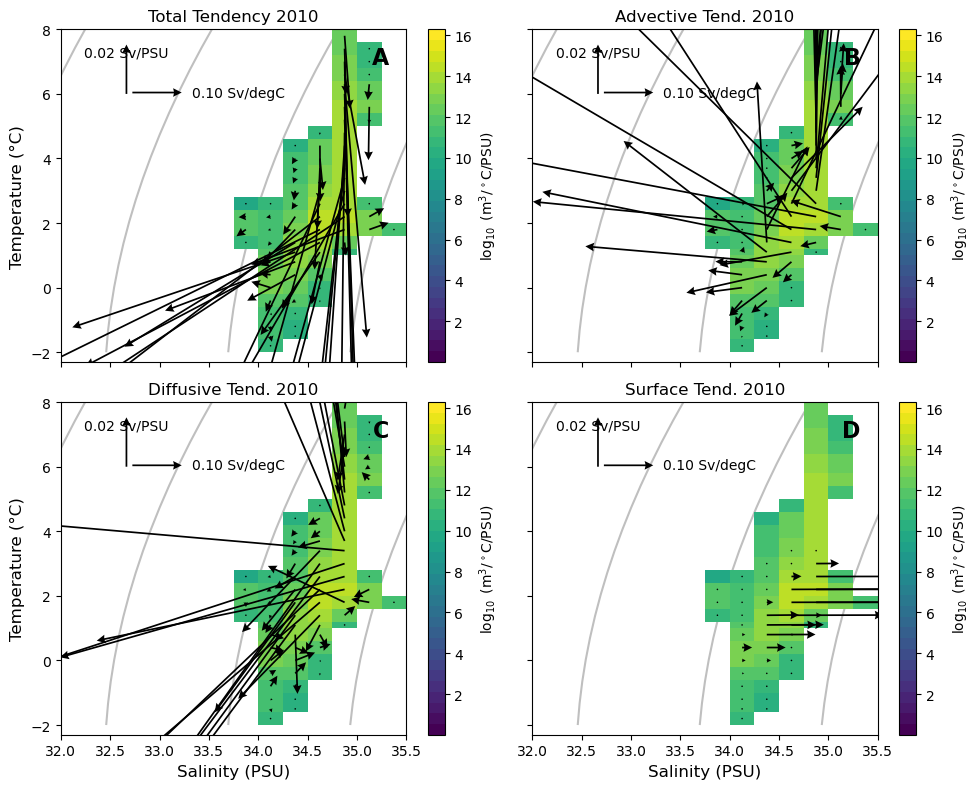

In [63]:
# make this a 2 by 2 instead

# Define constants
alpha, beta = 1, 0.2
arrow_length, step, t, U, scale = 0.25, 2, 0, .1, 0.7e0
ypos1, ypos2, xpos1, xpos2 = 0.81, 0.88, 0.35, 0.19

# Time string for labeling
timestr = "2010"

# Plot limits
xlims, ylims = np.array([32, 35.5]), np.array([-2.3, 8])

# Titles for each subplot
titles = [
    "Total Tendency", "Advective Tend.", "Diffusive Tend.",
    "KPP Tend.", "Surface Tend.", "Sum of Tendencies"
]

# Indices of plots to keep
plot_indices = [0, 1, 2, 4]  # Skip indices 3 and 5

# Figure setup (2x2 layout)
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
axes = axes.flatten()  # Flatten to easily index subplots

for j, i in enumerate(plot_indices):  # Iterate only over selected indices
    ax = axes[j]  # Pick corresponding subplot

    U1, V1 = JtermsS[i], JtermsT[i]  # Select tendency terms
    U1, V1 = U1 * alpha, V1 * beta  # Apply scaling
    U1[U1 == 0], V1[V1 == 0] = np.nan, np.nan  # Set zero values to NaN

    # Background colormap
    cb = ax.pcolormesh(Sbin, Tbin, np.log10(vol_mesh), cmap=cmap2, vmin=0.01, zorder=2)

    # Quiver plot
    q = ax.quiver(Sbincent, Tbincent, 
                  U1, V1, 
                  width=0.005, scale=scale, zorder=3, headwidth=5)

    # Colorbar
    plt.colorbar(cb, ax=ax, label=r'$\log_{10}\ (\mathrm{m^3/^\circ C/PSU})$')

    # Titles, limits, and labels
    ax.set_title(f"{titles[i]} {timestr}")
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)

    # Quiver key (for scale reference)
    ax.quiverkey(q, X=xpos1, Y=ypos1, U=U, label=f"{U*alpha:.2f} Sv/degC", labelpos='E')
    ax.quiverkey(q, X=xpos2, Y=ypos2, U=U, label=f"{U*beta:.2f} Sv/PSU", angle=90, labelpos='N', coordinates='axes')

    # Label each subplot (A, B, C, etc.)
    if i in {0,1,2}:
        ax.text(0.95, 0.95, chr(65 + i), transform=ax.transAxes, fontsize=16, fontweight='bold', 
            va='top', ha='right')
    else:
        ax.text(0.95, 0.95, "D", transform=ax.transAxes, fontsize=16, fontweight='bold', 
            va='top', ha='right')

    # Density contours
    cs = ax.contour(si, ti, dens2, colors="grey", zorder=1, alpha=0.5, levels=np.arange(16, 32, 1))
    ax.clabel(cs, fontsize=10, inline=False, fmt="%.f")

# Set x and y labels for shared axes
for ax in axes[-2:]:  # Bottom row
    ax.set_xlabel("Salinity (PSU)", fontsize=12)

for ax in axes[::2]:  # Left column
    ax.set_ylabel("Temperature (°C)", fontsize=12)

# Adjust layout
plt.tight_layout()

# Save figure
plt.savefig(path + titlestr + "full_sansKPP" + timestr + ".png", dpi=300)
plt.show()

In [64]:
path

'figs/WMT'

# do a sample plot of the convergence for this

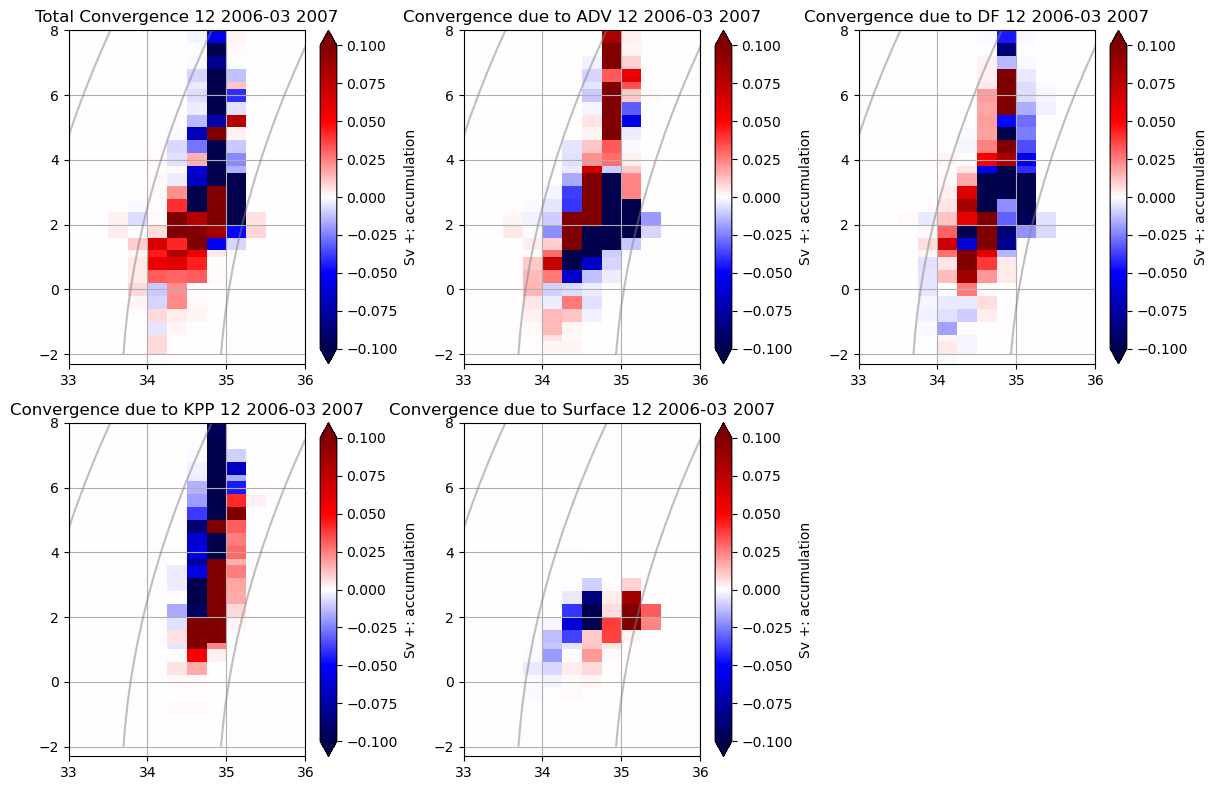

In [66]:
# Define constants
vlev = 0.1  # Divergence normalization level
titles = [
    "Total Convergence", "Convergence due to ADV", "Convergence due to DF",
    "Convergence due to KPP", "Convergence due to Surface"
]

# Time string for labeling
# timestr = datetimes[0].strftime("%Y") + "-" + datetimes[-1].strftime("%Y")
# timestr = datetimes[0].strftime("%m") + "-" + datetimes[5].strftime("%m") + "_" +datetimes[0].strftime("%Y") + "-" + datetimes[-1].strftime("%Y")
# timestr = "2010"
timestr = datetimes[0].strftime("%m %Y") + "-" +datetimes[-1].strftime("%m %Y")

xlims, ylims = np.array([33, 36]), np.array([-2.3, 8])

# Create figure
fig, axes = plt.subplots(2, 3, figsize=(12, 8))  # 2x3 grid
axes = axes.flatten()  # Flatten to make looping easier

# Loop through the 5 tendencies and plot
for i, ax in enumerate(axes[:-1]):  # Last subplot will be empty in 2x3 layout
    U1, V1 = JtermsS_nn[i], JtermsT_nn[i]

    # Convert zeros to NaN
    #U1[U1 == 0], V1[V1 == 0] = np.nan, np.nan

    # Compute divergence
    divergence = np.gradient(U1, axis=0) + np.gradient(V1, axis=1)
    convergence = - (divergence)


    # Background colormap using divergence
    cb = ax.pcolormesh(Sbin, Tbin, convergence, cmap='seismic', vmin=-vlev, vmax=vlev)
    plt.colorbar(cb, ax=ax, label="Sv +: accumulation", extend="both")

    # Set title, limits, and grid
    ax.set_title(f"{titles[i]} {timestr}")
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    ax.grid()

    # Density contours
    cs = ax.contour(si, ti, dens2, colors="grey", zorder=2, alpha=0.5, levels=np.arange(16, 32, 1))
    ax.clabel(cs, fontsize=10, inline=False, fmt="%.f")

# Remove last (unused) subplot for a cleaner layout
fig.delaxes(axes[-1])

# Adjust layout and save figure
plt.tight_layout()
plt.savefig(path + titlestr + "convergencefull" + timestr + ".png", dpi=300)
plt.show()

# In the surface, we want to know what is causing an depletion of freshwater/formation of salty water

- identify S ranges for anomalies between the two sets of years in terms of volume (we first need the overall transformation)
- identify divergence TS bins in the tendency
- integrate these to get one number per year for each adv, df, surface, kpp term
- plot this as a time series 

In [261]:
# binsSLT_edges
# Sbin
# Sbincent.shape
# test = np.where(Sbin[:, 0] <= S_max)[0][-1]

-6.94106483355313


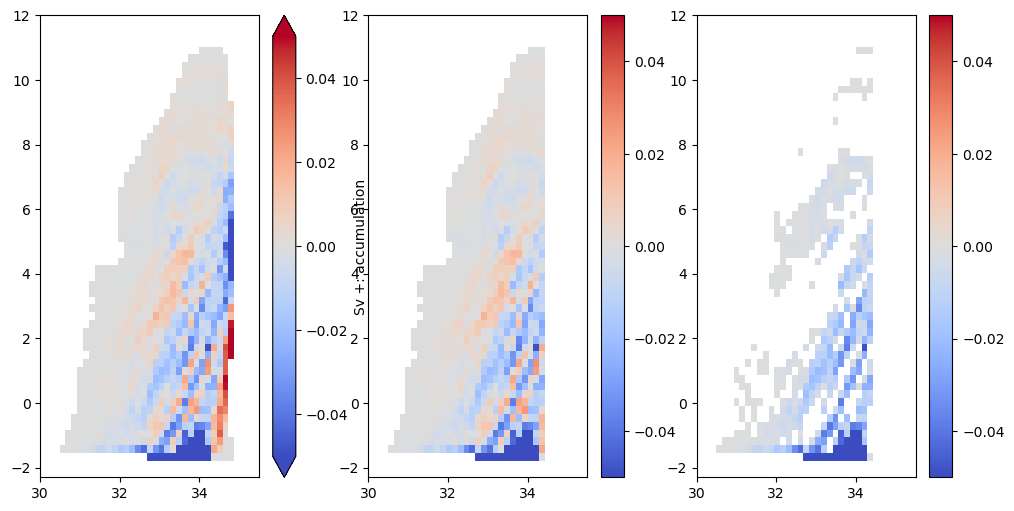

In [24]:
S_max = 34.5
S_max_idx = np.where(Sbin[:, 0] <= S_max)[0][-1]

# test our convergence calculation
convergence = - (np.gradient(U1, axis=0) + np.gradient(V1, axis=1))  # + : accumulation of water

# look for negative values beneath the threshold
masked_conv = np.full_like(convergence, np.nan)  # Initialize with NaNs
masked_conv[:S_max_idx,:] = convergence[:S_max_idx,:]  # Keep only selected salinities
negative_convergence = np.where(masked_conv < 0, convergence, np.nan)
# summed_negative_convergence = np.nansum(convergence, axis=1)

# Plot the masked data
fig = plt.figure(figsize=(12, 6))

# total convergence
ax = plt.subplot(131)
cb = ax.pcolormesh(Sbin, Tbin, convergence, cmap='coolwarm', vmin=-vlev, vmax=vlev)
plt.colorbar(cb, ax=ax, label="Sv +: accumulation", extend="both")

ax.set_xlim(xlims)
ax.set_ylim(ylims)

# selected convergence
ax = plt.subplot(132)
cb = ax.pcolormesh(Sbin, Tbin, masked_conv, cmap="coolwarm", zorder=2,vmin=-vlev, vmax=vlev)
plt.colorbar(cb)

# Add colorbar
ax.set_xlim(xlims)
ax.set_ylim(ylims)

# negative convergence
ax = plt.subplot(133)
cb = ax.pcolormesh(Sbin, Tbin, negative_convergence, cmap="coolwarm", zorder=2,vmin=-vlev, vmax=vlev)
plt.colorbar(cb)

# Add colorbar
ax.set_xlim(xlims)
ax.set_ylim(ylims)

print(np.nansum(negative_convergence))  # Sv of destroyed water by surface processes (this was the last convergence we calculated)

In [25]:
# set the S range we want to use
S_max = 34.5
FW_convergence_lists = [[] for _ in range(5)]  # Creates five empty lists

# figure out which index of S bins these are from binsSLT_edges
S_max_idx = np.where(Sbin[:, 0] <= S_max)[0][-1]

# for each time step
for i in range(len(tsstr)-1):
    # for each J term in JtermsS_nn_all
    for j in range(5):
        # get the convergence of S terms
        U1, V1 = JtermsS_nn_all[i][j], JtermsT_nn_all[i][j]
        U1[U1 == 0], V1[V1 == 0] = np.nan, np.nan
        convergence = - (np.gradient(U1, axis=0) + np.gradient(V1, axis=1))  # + : accumulation of water

        # look for negative values beneath the threshold
        masked_conv = np.full_like(convergence, np.nan)  # Initialize with NaNs
        masked_conv[:S_max_idx,:] = convergence[:S_max_idx,:]  # Keep only selected salinities
        negative_convergence = np.where(masked_conv < 0, convergence, np.nan)
        summed_negative_convergence = np.nansum(negative_convergence)

        # append this value to the correct list
        FW_convergence_lists[j].append(summed_negative_convergence)

In [26]:
# labels
labels = ["Total","ADV","DF","KPP","surf"]

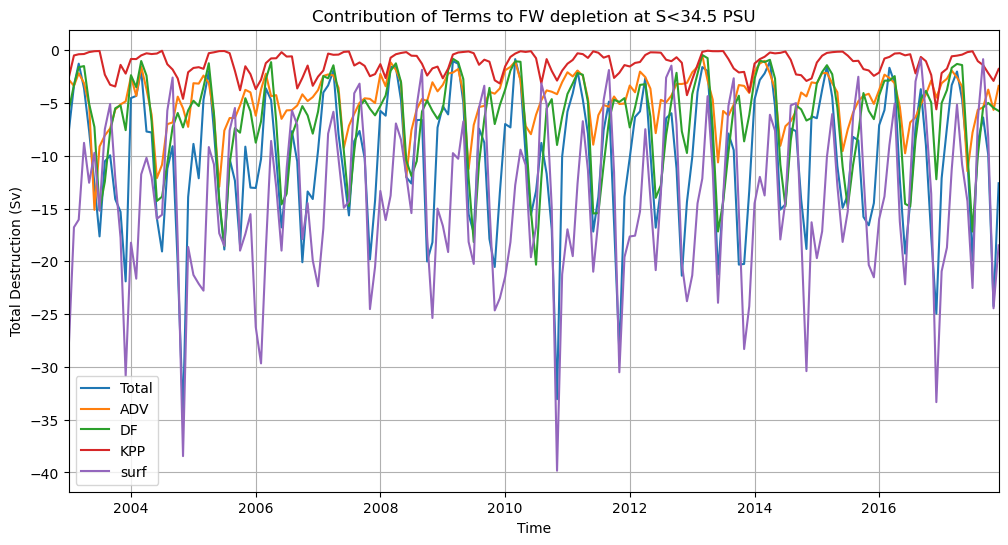

In [27]:
# now plot which terms over time are contributing to this

# Create a single plot for all J terms
fig, ax = plt.subplots(figsize=(12, 6))

# Plot each list against tsstr
for j in range(5):
    ax.plot(datetimes[:-1], FW_convergence_lists[j], linestyle='-', label=labels[j])

# Set labels and title
ax.set_xlabel("Time")
ax.set_ylabel("Total Destruction (Sv)")
ax.set_title("Contribution of Terms to FW depletion at S<"+ str(S_max)+" PSU")
ax.grid(True)
ax.set_xlim(datetimes[0],datetimes[-2])

# Add legend
ax.legend()

# Show plot
plt.show()

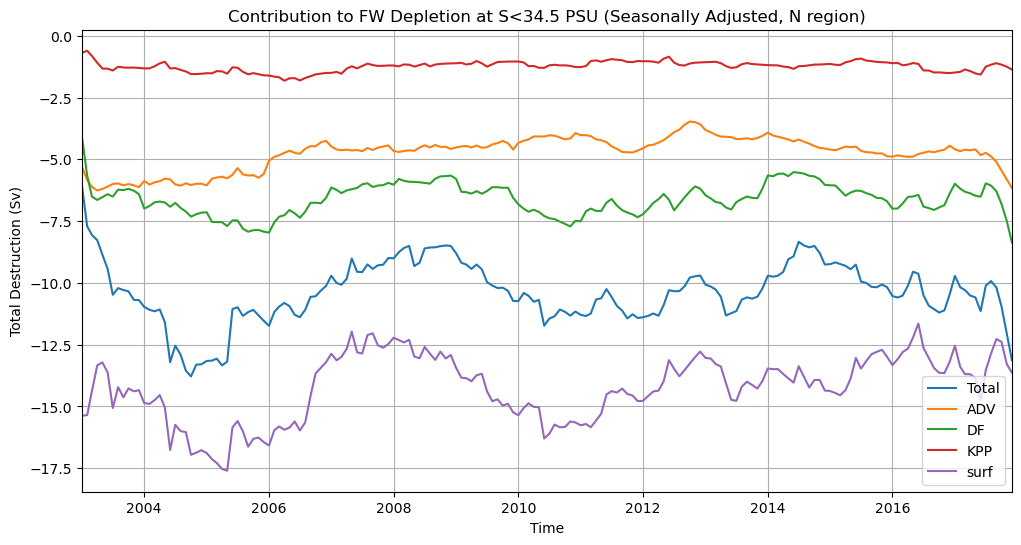

In [28]:
# Convert datetimes to Pandas DatetimeIndex
datetimes_toplot = pd.to_datetime(datetimes[:-1])

# Create a figure
fig, ax = plt.subplots(figsize=(12, 6))

# Apply a 12-month moving average to remove seasonal variability
window_size = 12  # Adjust this based on your data's seasonality

for j in range(5):
    fw_series = pd.Series(FW_convergence_lists[j], index=datetimes_toplot)
    smoothed_fw = fw_series.rolling(window=window_size, center=True, min_periods=1).mean()  # Rolling mean
    
    ax.plot(datetimes_toplot, smoothed_fw, linestyle='-', label=labels[j])

# Set labels and title
ax.set_xlabel("Time")
ax.set_ylabel("Total Destruction (Sv)")
ax.set_title(f"Contribution to FW Depletion at S<{S_max} PSU (Seasonally Adjusted, N region)")
ax.grid(True)
ax.set_xlim(datetimes[0], datetimes[-2])

# Add legend
ax.legend()

# Show plot
plt.show()

In [29]:
allyears = np.arange(2003,2008,1)
allyears = np.arange(2013,2018,1)
allyears = np.arange(2003,2018,1)

In [30]:
# we should also plot the sea ice extent on the same plot but make it on the other axis
# do the sea ice area as a map
si_area_all = np.full((len(allyears),12,ny,nx),np.nan)
iy = 0
for year in allyears:
    print(year)

    # get the datetime values
    # years = list(np.arange(2003,2018,1))  # 15 year period
    years = list(np.arange(year,year+1,1))
    years = [str(i) for i in years]
    years = np.array(years)
    # write the datetimes for the later period
    times = {}
    
    for year in years:
        times[year] = np.arange(1,13,1)   # write all the months for this example 5-year period
    
    tsstr2,datetimes2 = get_tsteps(times,fnames,dt_aste,startyr,1,1)

    ## 
    # get the SIarea values

    SIarea = np.full((len(tsstr2),ny,nx),np.nan)  # 2D field 
    
    for i in range(len(tsstr2)):
    
        # read the fldList
        file_name = 'state_2d_set1'
        meta_state_2d_set1 = parsemeta(dirState + file_name + "." + tsstr2[i] + ".meta")
        fldlist = np.array(meta_state_2d_set1["fldList"])
        varnames = np.array(["SIarea"])
        recs = np.array([])
        for var in varnames:
            irec = np.where(fldlist == var)
            recs = np.append(recs, irec[0][0])
            
        read = [int(tsstr2[i])]
        
        # make sure order we write the variables is the same as the order in varnames, else we read the wrong thing
        # this is wrong, this is the fractional area -- to get the actual area we need to multiply by RAC
        SIareai,its,meta = rdmds(os.path.join(dirState, file_name),read,returnmeta=True,rec=recs[0])  # m^2/m^2
        SIarea[i,:,:] = np.reshape(SIareai,(ny,nx))*mymsk*RAC  # m^2

        # get the total SIarea for that time
        si_area_all[iy,i,:,:] = SIarea[i,:,:]

    iy += 1

2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017


In [31]:
# get the total sea ice area as a timeseries
si_area_all = si_area_all.reshape(allyears.shape[0]*len(tsstr2),ny,nx)
si_area_timeseries = np.array([])
for i in range(si_area_all.shape[0]):
    si_area_timeseries = np.append(si_area_timeseries,np.nansum(si_area_all[i]))

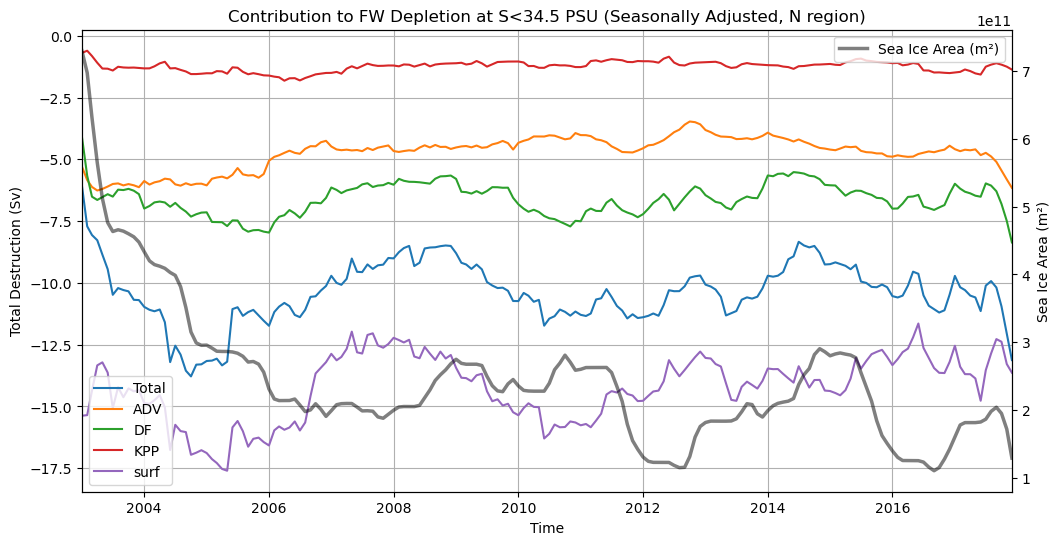

In [33]:
# Create a figure
fig, ax = plt.subplots(figsize=(12, 6))

# Apply a 12-month moving average to remove seasonal variability
window_size = 12  # Adjust this based on your data's seasonality

for j in range(5):
    # do the freshwater series
    fw_series = pd.Series(FW_convergence_lists[j], index=datetimes_toplot)
    smoothed_fw = fw_series.rolling(window=window_size, center=True, min_periods=1).mean()  # Rolling mean
    
    ax.plot(datetimes_toplot, smoothed_fw, linestyle='-', label=labels[j])

# do the siarea timeseries
ax2 = ax.twinx()

si_series = pd.Series(si_area_timeseries, index=datetimes_toplot)
smoothed_si = si_series.rolling(window=window_size, center=True, min_periods=1).mean()  # Rolling mean
ax2.plot(datetimes_toplot, smoothed_si, linestyle='-', color='black', linewidth=2.5, label="Sea Ice Area (m²)",alpha=0.5)

# Set labels and title
ax.set_xlabel("Time")
ax.set_ylabel("Total Destruction (Sv)")
ax.set_title(f"Contribution to FW Depletion at S<{S_max} PSU (Seasonally Adjusted, N region)")
ax.grid(True)
ax.set_xlim(datetimes_toplot[0], datetimes_toplot[-1])

ax2.set_ylabel("Sea Ice Area (m²)", color='black')

# Add legend
ax.legend(loc="lower left")
ax2.legend(loc="upper right")

# Show plot

plt.savefig(path + titlestr + "FW_destruction_contribution" + timestr + ".png", dpi=300)

# In the Atlantic Layer (identified by masking), we want to know what is causing an accumulation of warm water

- first plot the atlantic water layer in the N Barents Sea region for the two periods as a total transformation (probably T of 3-7, S>34.5)
- identify T anomalies between the two - what is the T-S range for AW that we are interested in
- identify TS bins where accumulation is happening
- integrate the TS bins for each term per year for adv, df, surface, kpp term
- plot this as a time series

24
42
1.0033297389768658


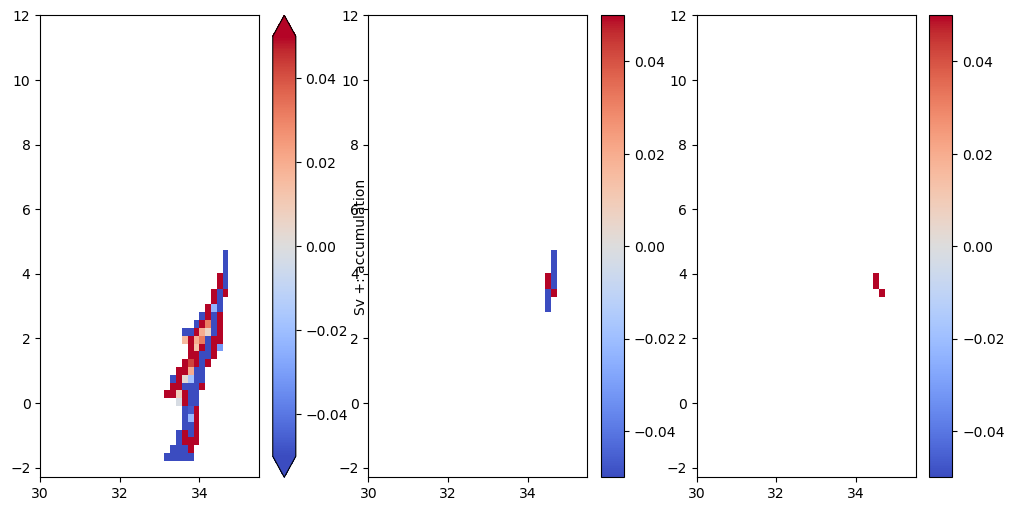

In [34]:
# do a check plot with a similar practice as we did before
# write the approximate values for AW
S_max = 34.5
S_max_idx = np.where(Sbin[:, 0] <= S_max)[0][-1]
T_min = 3
T_min_idx = np.where(Tbin[0, :] <= T_min)[0][-1]
print(T_min_idx)
T_max = 7
T_max_idx = np.where(Tbin[0, :] <= T_max)[0][-1] + 1  # for indexing properly and not cutting off values
print(T_max_idx)

# test our convergence calculation
convergence = - (np.gradient(U1, axis=0) + np.gradient(V1, axis=1))  # + : accumulation of water

# look for negative values within the threshold
masked_conv = np.full_like(convergence, np.nan)  # Initialize with NaNs
masked_conv[S_max_idx:,T_min_idx:T_max_idx] = convergence[S_max_idx:,T_min_idx:T_max_idx]  # Keep only selected salinities
positive_convergence = np.where(masked_conv > 0, convergence, np.nan)
# summed_negative_convergence = np.nansum(convergence, axis=1)

# Plot the masked data
fig = plt.figure(figsize=(12, 6))

# total convergence
ax = plt.subplot(131)
cb = ax.pcolormesh(Sbin, Tbin, convergence, cmap='coolwarm', vmin=-vlev, vmax=vlev)
plt.colorbar(cb, ax=ax, label="Sv +: accumulation", extend="both")

ax.set_xlim(xlims)
ax.set_ylim(ylims)

# selected convergence
ax = plt.subplot(132)
cb = ax.pcolormesh(Sbin, Tbin, masked_conv, cmap="coolwarm", zorder=2,vmin=-vlev, vmax=vlev)
plt.colorbar(cb)

# Add colorbar
ax.set_xlim(xlims)
ax.set_ylim(ylims)

# negative convergence
ax = plt.subplot(133)
cb = ax.pcolormesh(Sbin, Tbin, positive_convergence, cmap="coolwarm", zorder=2,vmin=-vlev, vmax=vlev)
plt.colorbar(cb)

# Add colorbar
ax.set_xlim(xlims)
ax.set_ylim(ylims)

print(np.nansum(positive_convergence))  # Sv of destroyed water by surface processes (this was the last convergence we calculated)
# this makes sense because surface processes are not really creating AW

In [311]:
# we copy the similar syntax from before but here we can make a T range rather than an S range

# look for warm water above some threshold for accumulation of heat

# set the S range we want to use
AW_convergence_lists = [[] for _ in range(5)]  # Creates five empty lists

# for each time step
for i in range(len(tsstr)-1):
    # for each J term in JtermsS_nn_all
    for j in range(5):
        # get the convergence of S terms
        U1, V1 = JtermsS_nn_all[i][j], JtermsT_nn_all[i][j]
        U1[U1 == 0], V1[V1 == 0] = np.nan, np.nan
        convergence = - (np.gradient(U1, axis=0) + np.gradient(V1, axis=1))  # + : accumulation of water

        # look for negative values beneath the threshold
        masked_conv = np.full_like(convergence, np.nan)  # Initialize with NaNs
        masked_conv[S_max_idx:,T_min_idx:T_max_idx] = convergence[S_max_idx:,T_min_idx:T_max_idx]  # Keep only selected salinities
        positive_convergence = np.where(masked_conv > 0, convergence, np.nan)
        summed_positive_convergence = np.nansum(positive_convergence)

        # append this value to the correct list
        AW_convergence_lists[j].append(summed_positive_convergence)

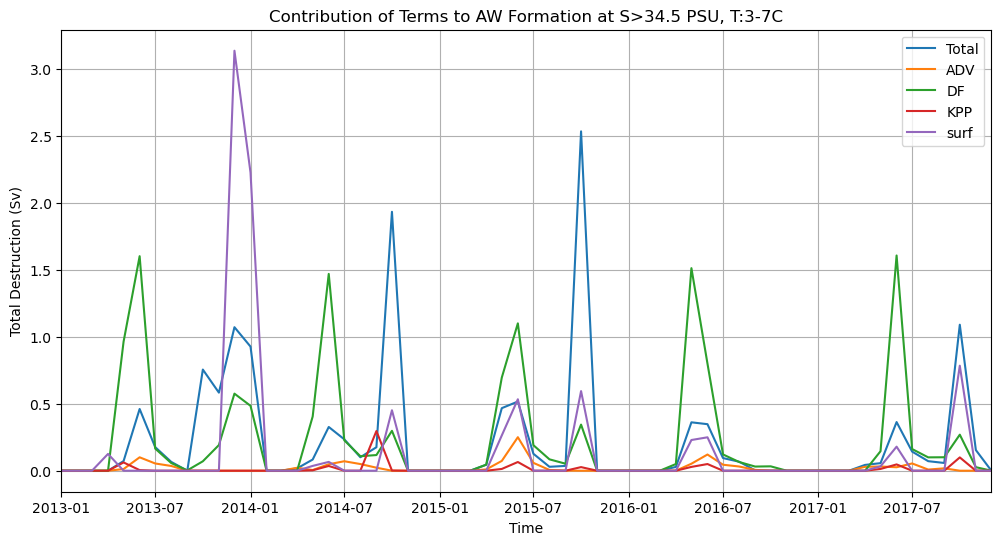

In [312]:
# can plot the messy timeseries with seasonal distributions
# now plot which terms over time are contributing to this

# Create a single plot for all J terms
fig, ax = plt.subplots(figsize=(12, 6))

# Plot each list against tsstr
for j in range(5):
    ax.plot(datetimes[:-1], AW_convergence_lists[j], linestyle='-', label=labels[j])

# Set labels and title
ax.set_xlabel("Time")
ax.set_ylabel("Total Destruction (Sv)")
ax.set_title("Contribution of Terms to AW Formation at S>"+ str(S_max)+" PSU, T:"+str(T_min)+"-"+str(T_max)+"C")
ax.grid(True)
ax.set_xlim(datetimes[0],datetimes[-2])

# Add legend
ax.legend()

# Show plot
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


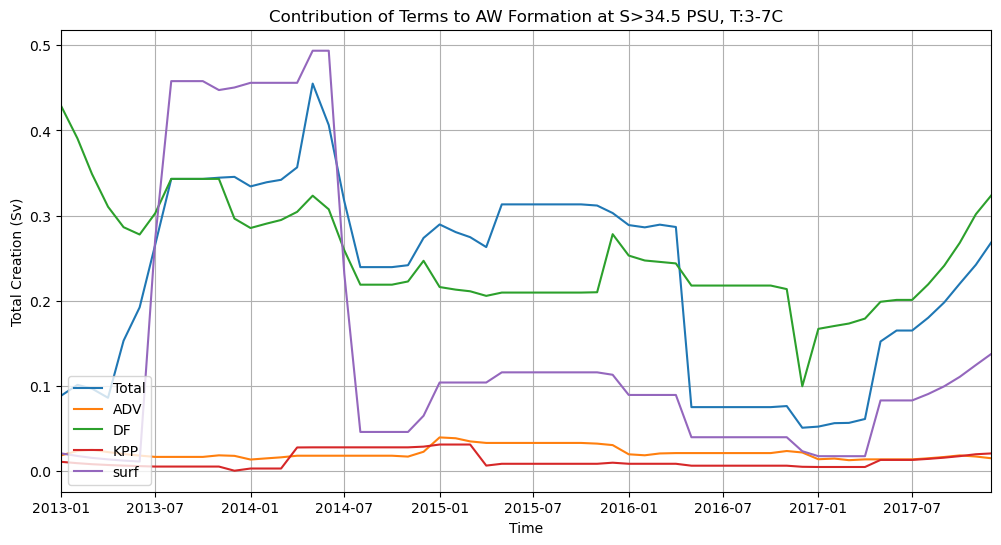

In [317]:
# Create a figure
fig, ax = plt.subplots(figsize=(12, 6))

# Apply a 12-month moving average to remove seasonal variability
window_size = 12  # Adjust this based on your data's seasonality

for j in range(5):
    # do the freshwater series
    fw_series = pd.Series(AW_convergence_lists[j], index=datetimes_toplot)
    smoothed_fw = fw_series.rolling(window=window_size, center=True, min_periods=1).mean()  # Rolling mean
    
    ax.plot(datetimes_toplot, smoothed_fw, linestyle='-', label=labels[j])

# do the siarea timeseries
# ax2 = ax.twinx()

# si_series = pd.Series(si_area_timeseries, index=datetimes_toplot)
# smoothed_si = si_series.rolling(window=window_size, center=True, min_periods=1).mean()  # Rolling mean
# ax2.plot(datetimes_toplot, smoothed_si, linestyle='-', color='black', linewidth=2.5, label="Sea Ice Area (m²)",alpha=0.5)

# Set labels and title
ax.set_xlabel("Time")
ax.set_ylabel("Total Creation (Sv)")
ax.set_title("Contribution of Terms to AW Formation at S>"+ str(S_max)+" PSU, T:"+str(T_min)+"-"+str(T_max)+"C")
ax.grid(True)
ax.set_xlim(datetimes_toplot[0], datetimes_toplot[-1])

ax2.set_ylabel("Sea Ice Area (m²)", color='black')

# Add legend
ax.legend(loc="lower left")
ax2.legend(loc="upper right")

# Show plot

plt.savefig(path + titlestr + "AW_creation_contribution" + timestr + ".png", dpi=300)